# Intro

This script is developed to examine to data of 'HR_data.csv', assumed to be located in the folder 'data'.
It makes use of the packages 'numpy', 'pandas', 'matplotlib', 'scikit-learn', and 'scipy'.

### Setup

In [1]:
# Set environment
import warnings
warnings.filterwarnings('ignore')
rdst = 27

# Load libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, leaves_list
from scipy.spatial.distance import pdist
from collections import Counter

### Data

The data set is divided into subsets for easier handling in the following section.

In [2]:
# Load data set
data = pd.read_csv("data/HR_data.csv")

# Separate depending on feature category
idx_data = data.iloc[:, 0]
eda_data = data.loc[:, data.columns.str.startswith("EDA")]
hr_data = data.loc[:, data.columns.str.startswith("HR")]
temp_data = data.loc[:, data.columns.str.startswith("TEMP")]
quest_data = data[['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']]

cols_to_drop = eda_data.columns.union(hr_data.columns).union(temp_data.columns).union(quest_data.columns)
cols_to_drop = cols_to_drop.union([data.columns[0]])
misc_data = data.drop(columns=cols_to_drop)

### Functions

Below are functions defined, used throughout this script.

In [3]:
def dissimilarity(X, labels, k):

    '''
    Compute dissimilarity as defined by Birchfield–Tomasi (1998).

    Inputs:
    X - DataFrame containing observations.
    labels - Array of assigned clusters.
    k - Scalar defining number of clusters.

    Output:
    W_k - within cluster dissimilarity.
    '''
    
    W_k = 0
    
    for cluster in range(k):
        observations = X[labels == cluster]
        N_l = observations.shape[0]
        
        if N_l > 1:
            D_l = np.sum(pdist(observations, metric='euclidean')**2)
            W_k += D_l / (2 * N_l)

    return W_k

In [4]:
# Define class for Hierarchical model to use with Gap statistics
class HierarchicalModel:

    '''
    
    Uses scipy.cluster.hierarchy functions fcluster and linkage to perform hierarchical clustering.

    Z can be provided or will calculated using the given method.

    Adjustments:
    method - single, complete, average, weighted, centroid, median, ward
    criterion - inconsistent, distance, maxclust, monocrit, maxclust_monocrit
    
    '''
    
    def __init__(self, method='ward', criterion='maxclust', Z=None):
        self.method = method
        self.criterion = criterion
        self.Z = Z
        self.n_clusters = None

    def set_params(self, **params):
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        # If Z not provided, compute it later from data in fit_predict

    def fit_predict(self, X):
        # Compute linkage if not already provided
        if self.Z is None:
            self.Z = linkage(X, method=self.method)
            
        return fcluster(self.Z, self.n_clusters, criterion=self.criterion) - 1

In [5]:
def gap_statistics(X, k_max, references=20, random_state=None, model=None):

    '''
    
    Compute gap statistics of clustering method on data set vs simulated reference data.

    Inputs:
    X - DataFrame containing observations.
    k_max - Scalar defining max number of clusters to test.
    references - Scalar defining number of reference data to simulate.
    model - Clustering model to use. Model should take paramters n_clusters and method fit_predict.

    Output:
    log_W_k - log of within cluster dissimilarity of observations.
    expected_log_W_k - log of within cluster dissimilarity of simualted reference data.
    gaps - vector of differences in W_k between observations and simulated reference data.
    gap_diff - vector of difference in gaps between clusters.
    s_k_ref - standard deviations of W_k of simualted reference data.
    s_prime_k - standard error of k calculated from s_k_ref.
    optimal_k - optimal number of cluster determined by the 1-standard error rule.
    
    '''

    if model is None:
        print ('Define clustering model for gap statistics.')
        return

    # Initiate parameters
    log_W_k = np.zeros(k_max - 1)
    expected_log_W_k = np.zeros(k_max - 1)
    gaps = np.zeros(k_max - 1)
    gap_diff = np.zeros(k_max - 2)
    s_k_ref = np.zeros(k_max - 1)
    
    for k in range(2, k_max + 1):
        # Set model paramters and fit to data
        model.set_params(n_clusters = k, random_state = random_state)
        labels = model.fit_predict(X)
        W_k = dissimilarity(X, labels, k)
        log_W_k[k - 2] = np.log(W_k)

        # Dissimilarities for reference data sets
        ref_W_k = np.zeros(references)
        
        for i in range(references):
            # Simulate reference datasets and fit model to each
            reference = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=X.shape)
            ref_labels = model.fit_predict(reference)
            ref_W_k[i] = dissimilarity(reference, ref_labels, k)

        # Expected log(W_k) is the mean of reference log dissimilarities
        expected_log_W_k[k - 2] = np.mean(np.log(ref_W_k))
        
        # Gaps are expected_log_W_k - log_W_k
        gaps[k - 2] = expected_log_W_k[k - 2] - log_W_k[k - 2]
        
        # Standard deviation of reference log dissimilarities
        s_k_ref[k - 2] = np.std(np.log(ref_W_k))
        
    for k in range(2, k_max):
        gap_diff[k - 2] = gaps[k - 1] - gaps[k - 2]

    # 1-SE Rule implementation: Gap(k) ≥ Gap(k+1) - s'(k+1)
    s_prime_k = s_k_ref * np.sqrt(1 + 1 / references)
    k_range = np.arange(2, k_max + 1)
    optimal_k = k_max

    for k in range(2, k_max):
        if gaps[k - 2] >= gaps[k - 1] - s_prime_k[k - 1]:
            optimal_k = k
            break

    
    return log_W_k, expected_log_W_k, gaps, gap_diff, s_k_ref, s_prime_k, optimal_k

# Emotional states

The first part of this script aims to cluster samples based on the emotions expressed through the questionaire dataset 'quest_data'.

## Data

### Missing values and odd features

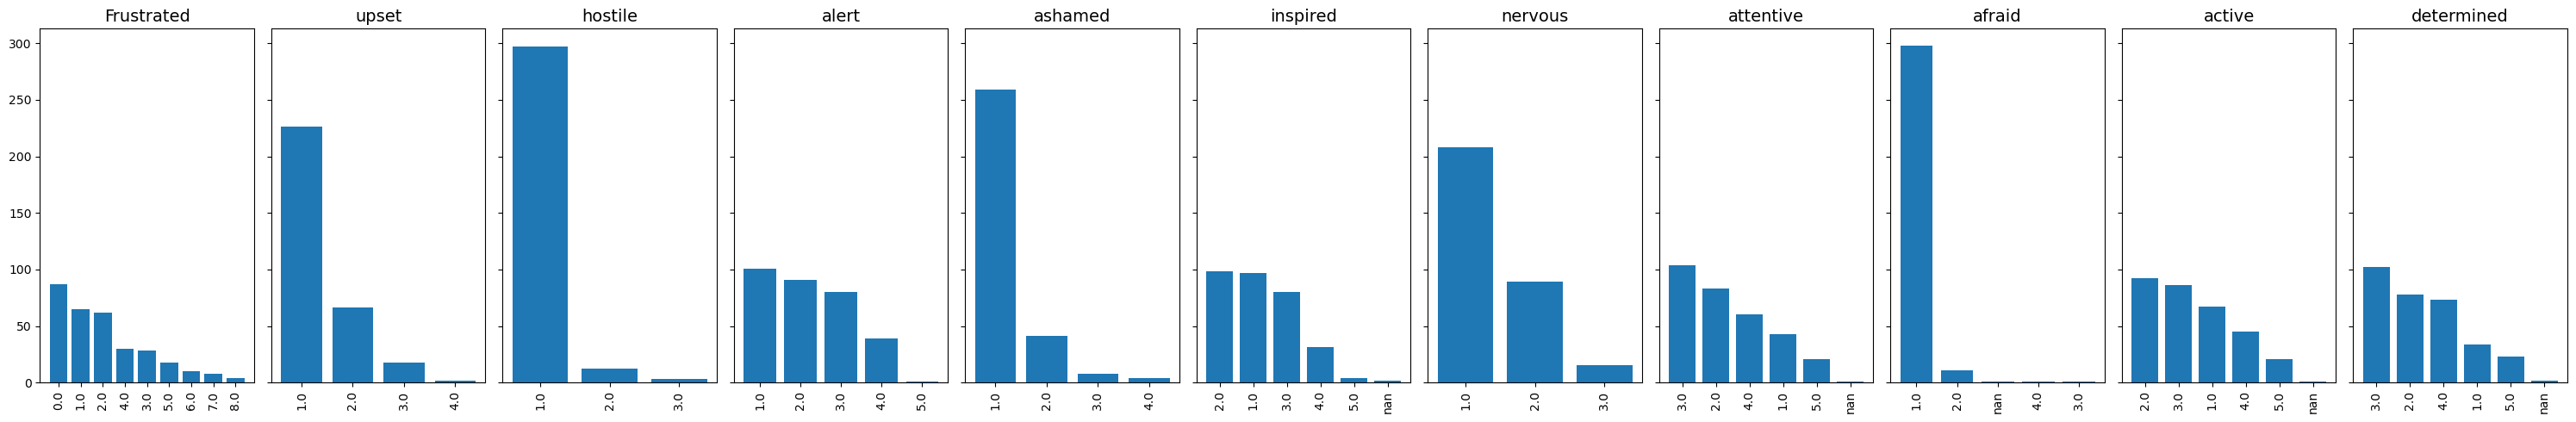

In [6]:
# Feature values
value_counts_per_feature = {
    col: quest_data[col].value_counts(dropna=False)
    for col in quest_data.columns}

# Plot values and NaNs
fig, axes = plt.subplots(1, 11, figsize=(30, 5), sharey=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(quest_data.columns):
    counts = quest_data[col].value_counts(dropna=False)
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(col, fontsize=14)
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

The features 'afraid' and 'hsotile' mainly takes the value 1, and are thus removed from future analysis. For the remaining data, rows contianing NaNs are removed.

In [7]:
# Remove 'afraid' and 'hostile' columns
quest_data_cleaned = quest_data.drop(columns=[col for col in quest_data.columns if 'afraid' in col or 'hostile' in col])

# Remove rows with remaining NaNs
nan_row_idx_quest = np.where(quest_data_cleaned.isna() == True)[0]
idx_quest_data_cleaned = idx_data.drop(np.unique(nan_row_idx_quest))
quest_data_cleaned = quest_data_cleaned.drop(np.unique(nan_row_idx_quest))

# Convert to integers
quest_data_cleaned = quest_data_cleaned.astype(int)

### Scaling

In [8]:
# Normalize to range from 0 to 1
scaler = MinMaxScaler()
normalized_quest_data = pd.DataFrame(
    scaler.fit_transform(quest_data_cleaned),
    columns=quest_data_cleaned.columns,
    index=quest_data_cleaned.index)

In [9]:
# Define feature data
quest_feature_columns = normalized_quest_data.columns.tolist()
quest_features = normalized_quest_data[quest_feature_columns]

### PCA

Principal component analysis is performed and the projection onto the first 2 principal components are saved for future plotting.

In [10]:
# PCA for visualizing clusters
quest_pca = PCA(n_components=2)
quest_pca_result = quest_pca.fit_transform(quest_features)
normalized_quest_data['PCA1'] = quest_pca_result[:, 0]
normalized_quest_data['PCA2'] = quest_pca_result[:, 1]

## Heatmap

A heatmap is prouduced using a ward linkage matrix, to estimate k visually before applying clustering

[]

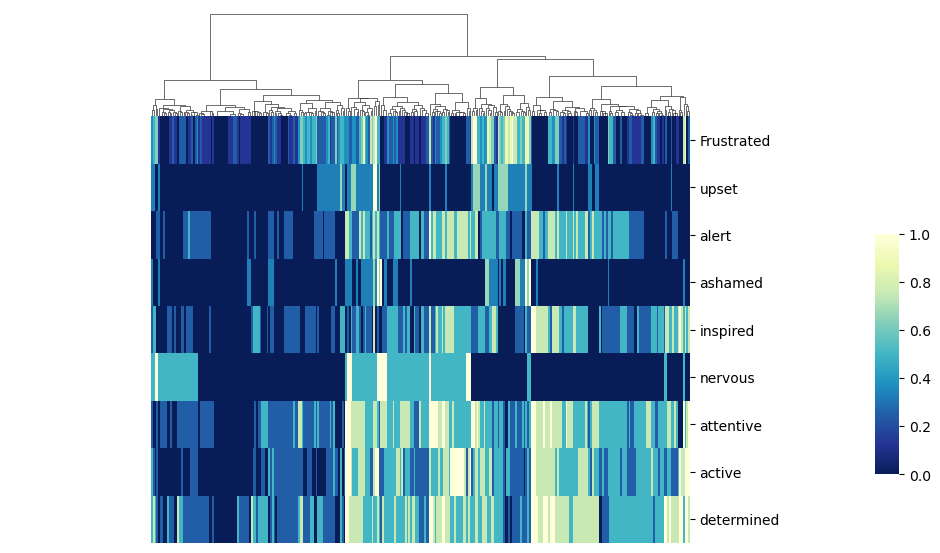

In [11]:
# Create linkage matrix
Z_quest = linkage(quest_features, method='ward')

# Plot heatmap with dendrograms
quest_heatmap = sn.clustermap(quest_features.T, cmap = 'YlGnBu_r', col_linkage = Z_quest, row_cluster = False,
                              col_cluster = True, figsize = (8, 6), cbar_pos = (1.1, .2, .03, .4))
quest_heatmap.ax_heatmap.set_xticks([])

## K-means

The heatmap displays signs of multiple clusters, and K-means clustering is performed to get stable, scalable clusters.

### Silhoutte

K-means is applied for different values of k, and average silhouette score for the cluster calculated.

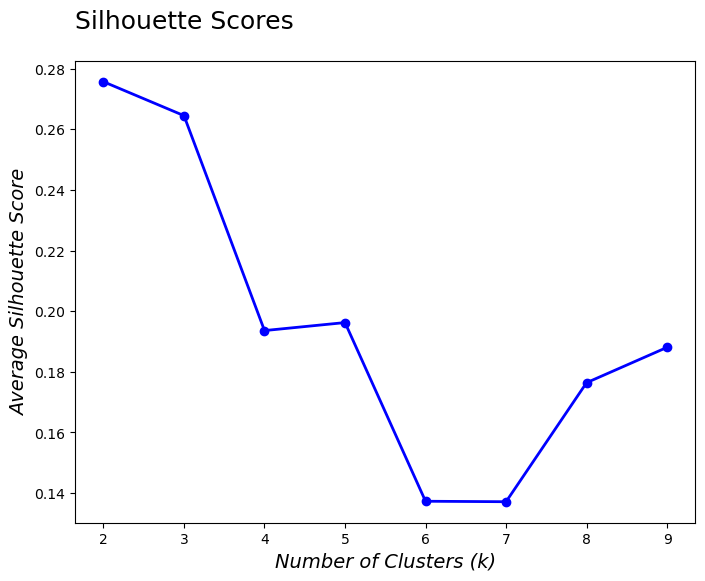

In [12]:
sil_scores = []
k_values = range(2, 10)

# Loop through k values
for k_val in k_values:
    model = KMeans(n_clusters = k_val, random_state = rdst)
    labels = model.fit_predict(quest_features)
    score = silhouette_score(quest_features, labels)
    sil_scores.append(score)

# Plot silhouette scores
kmeans_sil_avg, ax = plt.subplots(figsize=(8, 6))

ax = plt.plot(k_values, sil_scores, 'bo-', linewidth=2)
plt.ylabel("Average Silhouette Score", size = 14, fontstyle = 'italic')
plt.xlabel("Number of Clusters (k)", size = 14, fontstyle = 'italic')
plt.title('Silhouette Scores', y=1.1, pad=-10, loc='left', size=18)

plt.show()

Density plots of sample silhouette scores for k from 2 to 6 is plotted.

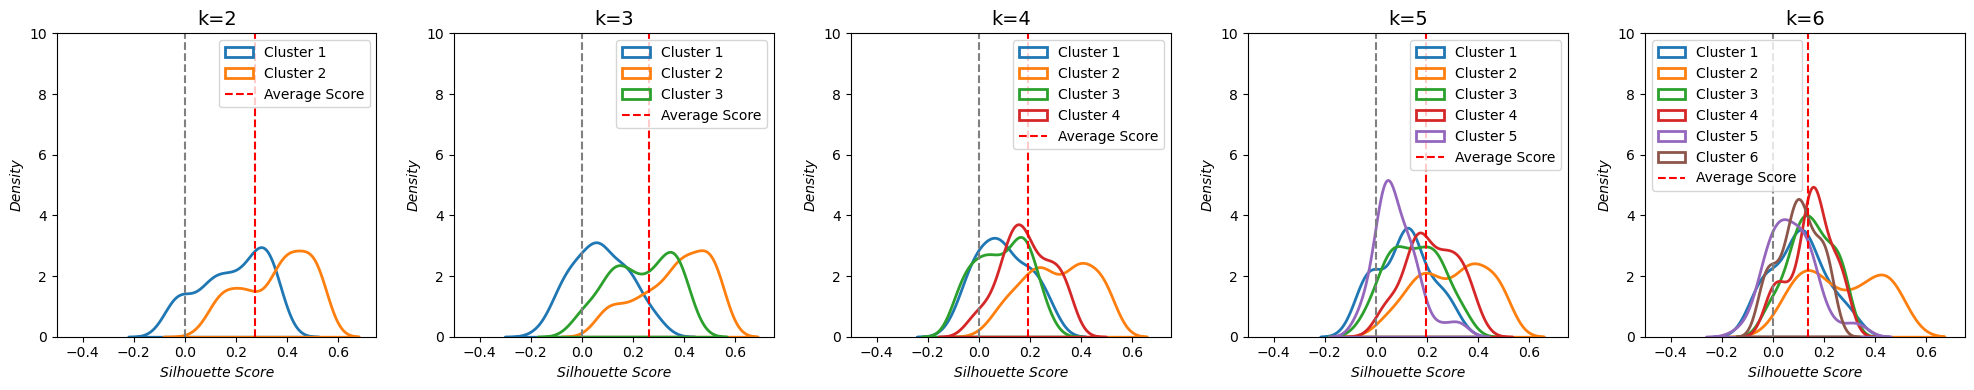

In [13]:
# Set up figure
kmeans_sil_distr, axes = plt.subplots(1, 5, figsize=(20, 4))
k_values = range(2, 7)

# Loop through k values
for idx, k_val in enumerate(k_values):
    
    # Fit KMeans model for k
    model = KMeans(n_clusters = k_val, random_state = rdst)
    labels = model.fit_predict(quest_features)
    
    # Calculate silhouette scores
    sil_scores = silhouette_samples(quest_features, labels)
    
    ax = axes[idx]
    
    # Create separate density plots for each cluster
    for i in range(k_val):
        cluster_sil_scores = sil_scores[labels == i]
        sn.kdeplot(cluster_sil_scores, ax = ax, shade = True, alpha = 0, lw = 2, label = f'Cluster {i+1}')
    
    # Add average silhouette score
    avg_score = silhouette_score(quest_features, labels)
    ax.axvline(x = avg_score, color = 'red', linestyle = '--', label = 'Average Score')

    # Add silhouette score = 0
    ax.axvline(x = 0, color = 'grey', linestyle = '--')
    
    ax.set_title(f'k={k_val}', size = 14)
    ax.set_xlim(-0.5, 0.75)
    ax.set_ylim(0, 10)
    ax.set_xlabel('Silhouette Score', size = 10, fontstyle = 'italic')
    ax.set_ylabel('Density', size = 10, fontstyle = 'italic')
    ax.legend()

plt.tight_layout()
plt.show()

## Gap statistics

The silhouette score indicates that the optimal amount of clusters is 2, but gap statistics is applied to evaluate this by comparing to a random sistribution.

Optimal number of clusters: 5


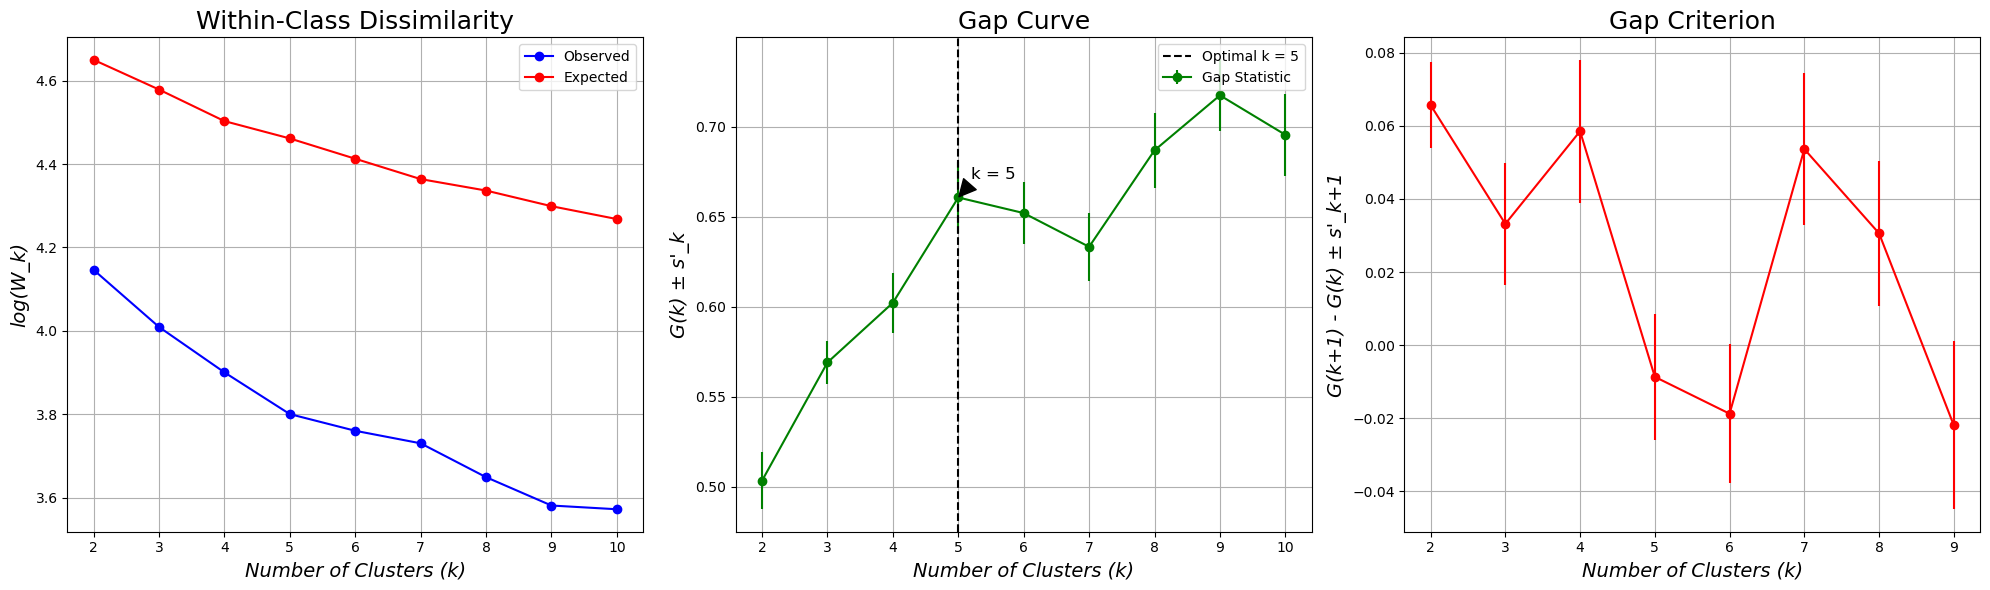

In [14]:
# Compute the gap statistics metrics
n_clusters = 10

(km_log_wk,
km_expected_log_wk,
km_gaps,
km_gap_diff,
km_s_k_ref,
km_s_prime_k,
km_k_1se) = gap_statistics(quest_features, n_clusters, references = 20, random_state = rdst, model = KMeans())

print(f'Optimal number of clusters: {km_k_1se}')

# Set up figure
kmeans_gap, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Within-Class Dissimilarity
axes[0].plot(range(2, n_clusters+1), km_log_wk, marker = 'o', color = 'b', label = 'Observed')
axes[0].plot(range(2, n_clusters+1), km_expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
axes[0].set_title('Within-Class Dissimilarity', size = 18)
axes[0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Gap Curve
axes[1].errorbar(range(2, n_clusters+1), km_gaps, yerr = km_s_prime_k, fmt = 'o-', color = 'g', label = 'Gap Statistic')
axes[1].axvline(x = km_k_1se, color = 'black', linestyle = '--', label = f'Optimal k = {km_k_1se}')
axes[1].annotate(f'k = {km_k_1se}', 
                 xy = (km_k_1se, km_gaps[km_k_1se - 2]), 
                 xytext = (km_k_1se + 0.2, km_gaps[km_k_1se - 2] + 0.01), 
                 arrowprops = dict(facecolor = 'black', shrink = 0.05),
                 fontsize = 12)
axes[1].set_title('Gap Curve', size = 18)
axes[1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
axes[1].grid(True)
axes[1].legend()

# Plot 3: Gap Criterion
axes[2].errorbar(range(2, n_clusters), km_gap_diff, yerr = km_s_prime_k[1:], fmt = 'o-', color = 'r', label = 'Gap Criterion')
axes[2].set_title('Gap Criterion', size = 18)
axes[2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Clustering

Gap statistics indicate that the optimal amount of clusters is 5.

In [15]:
# Fit KMeans
kmeans = KMeans(n_clusters = km_k_1se, random_state = rdst)
normalized_quest_data['quest_cluster_kmeans'] = kmeans.fit_predict(quest_features) +1
final_quest_data = pd.concat([idx_quest_data_cleaned, normalized_quest_data], axis=1)

# Print table of cluster mean center
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns = quest_features.columns)
cluster_centers.index = [f'Cluster {i+1}' for i in range(km_k_1se)]
display(cluster_centers)

,Frustrated,upset,alert,ashamed,inspired,nervous,attentive,active,determined
Cluster 1,0.720588,0.480392,0.360294,0.313725,0.205882,1.029412e-01,0.455882,0.426471,0.411765
Cluster 2,0.165441,0.049020,0.095588,0.022876,0.098039,1.176471e-01,0.188725,0.095588,0.223039
Cluster 3,0.224138,0.057471,0.616379,0.011494,0.586207,1.982759e-01,0.737069,0.754310,0.793103
Cluster 4,0.162698,0.052910,0.261905,0.021164,0.365079,-8.326673e-17,0.492063,0.436508,0.555556
Cluster 5,0.254902,0.130719,0.362745,0.156863,0.338235,6.372549e-01,0.568627,0.480392,0.583333


The projections are plotted over the 2 first principal components, and the cluster labels used to visualize the clusters.

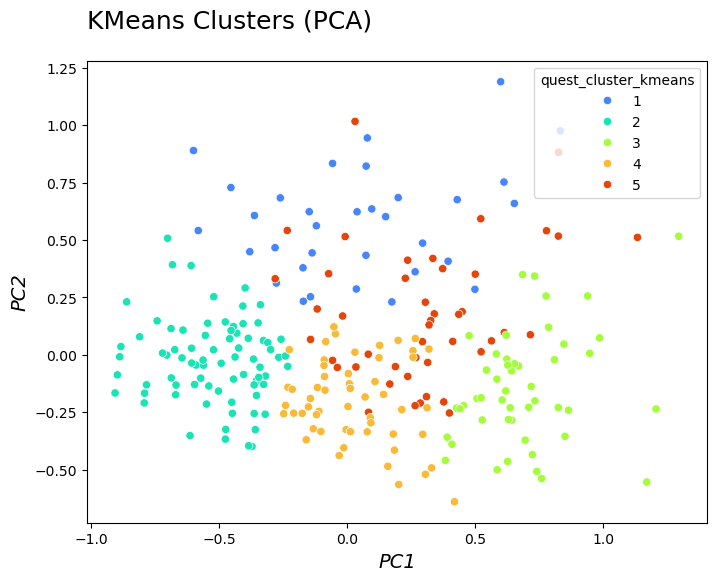

In [16]:
# Create colors based on kmeans
palette = sn.color_palette("turbo", km_k_1se)
cluster_labels = normalized_quest_data['quest_cluster_kmeans']
cluster_palette = {label: palette[label - 1] for label in sorted(cluster_labels.unique())}
cluster_colors = cluster_labels.map(lambda x: palette[x-1])

# Plot over principal components
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.scatterplot(data = normalized_quest_data, x = 'PCA1', y = 'PCA2', hue = 'quest_cluster_kmeans', palette = cluster_palette)
ax.set_xlabel('PC1', size = 14, fontstyle = 'italic')
ax.set_ylabel('PC2', size = 14, fontstyle = 'italic')
ax.set_title('KMeans Clusters (PCA)', y=1.1, pad=-10, loc='left', size=18)

plt.show()

Show heatmap with clusters predicted by k-means.

[]

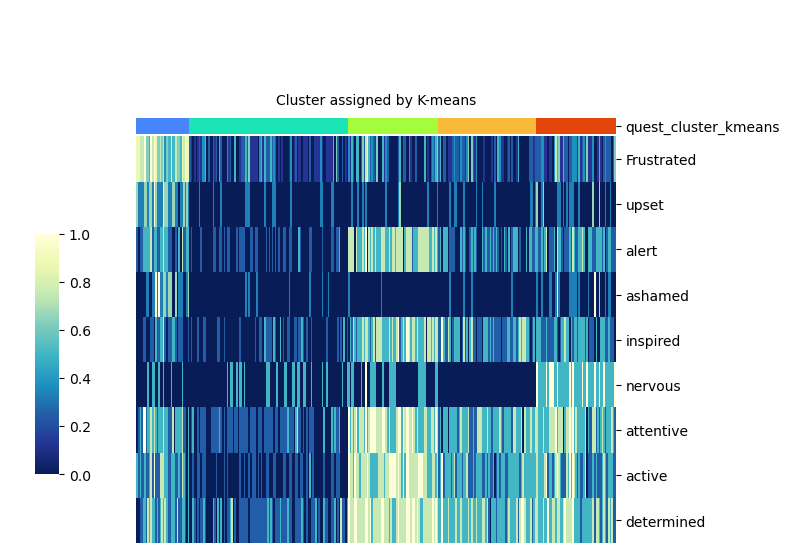

In [17]:
# Sort columns by cluster label
sorted_rows = cluster_labels.sort_values().index
quest_features_sorted = quest_features.loc[sorted_rows, :]

# Plot heatmap with cluster colors
quest_heatmap_km = sn.clustermap(quest_features_sorted.T, cmap = 'YlGnBu_r', row_cluster = False,
                                 col_colors=cluster_colors.loc[sorted_rows], col_cluster = False, figsize = (8, 6),
                                 cbar_pos = (0.05, .2, .03, .4))
quest_heatmap_km.ax_col_colors.set_title("Cluster assigned by K-means", fontsize=10, pad=10)
quest_heatmap_km.ax_heatmap.set_xticks([])

### Characterisitics

Characteristics of the identified clusters are explored, both for the distributions of the features within each cluster, but also settings of the original dataset that might correlate to the emotional state.

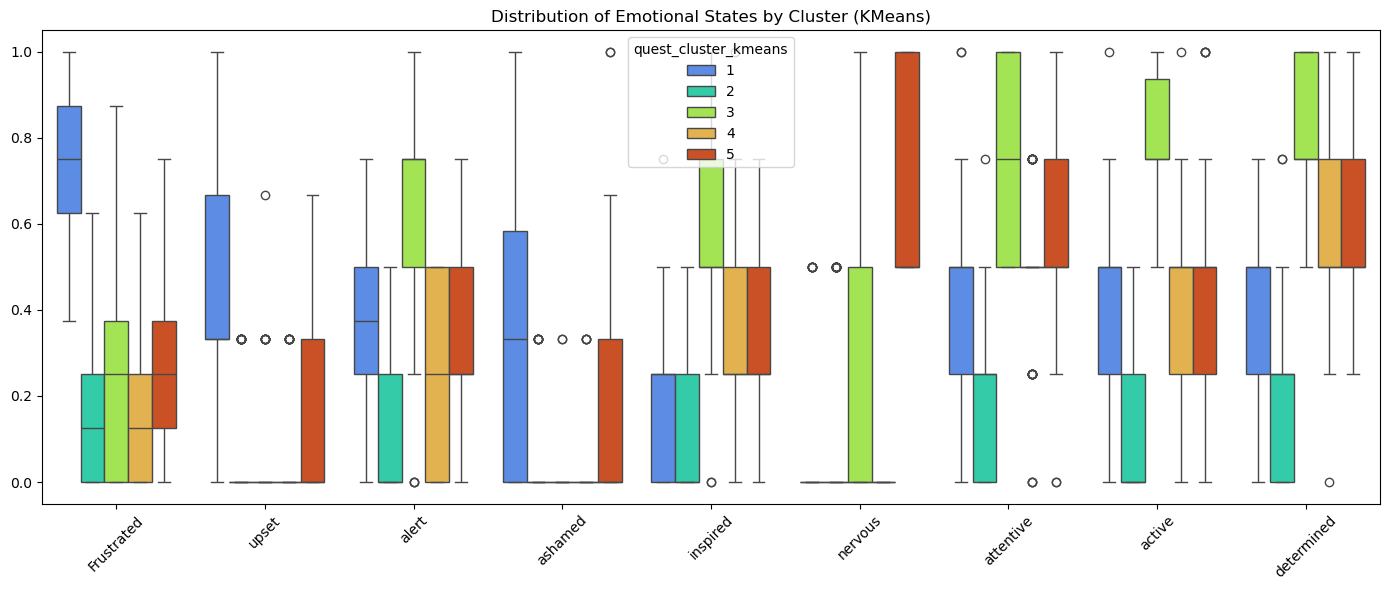

In [18]:
# Boxplots of questionaires for each cluster predicted by kmeans
kmeans_quest_melted = pd.melt(normalized_quest_data.reset_index(),
                              id_vars = 'quest_cluster_kmeans',
                              value_vars = quest_features.columns,
                              var_name = 'Question', value_name='Score')

plt.figure(figsize=(14, 6))
sn.boxplot(data = kmeans_quest_melted, x = 'Question', y = 'Score', hue = 'quest_cluster_kmeans', palette = cluster_palette)
plt.title("Distribution of Emotional States by Cluster (KMeans)")
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

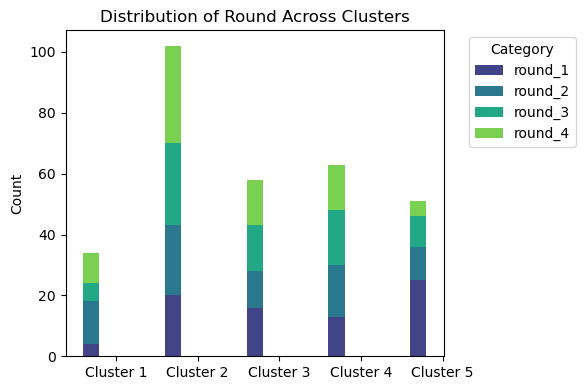

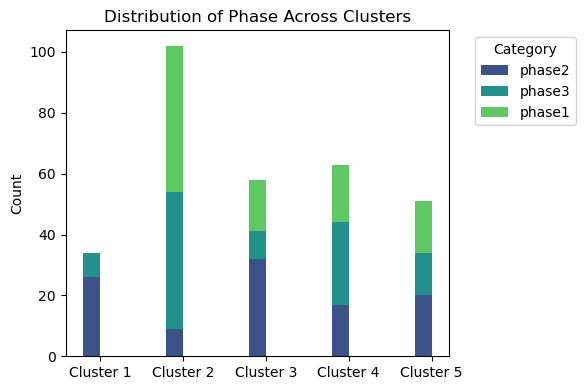

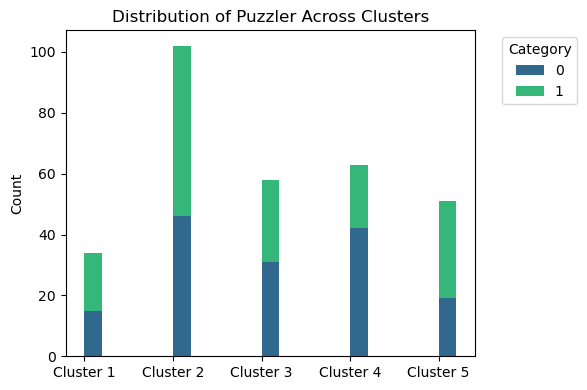

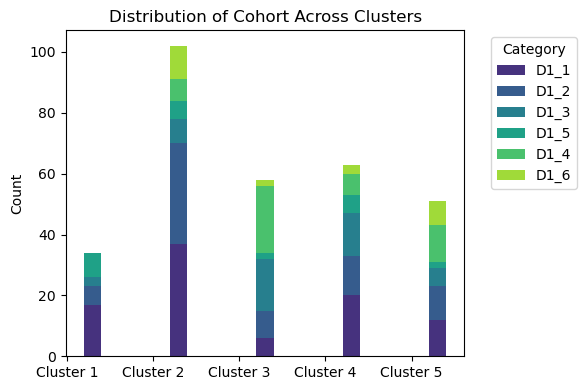

In [19]:
# Add cluster labels to misc data
misc_columns = [col for col in misc_data.columns if col != 'Individual']
misc_data_filtered = misc_data[misc_columns]
misc_data_clustered = misc_data.loc[normalized_quest_data.index].copy()
misc_data_clustered['Cluster'] = cluster_labels

# Melt the data for easier plotting
quest_melted_misc = misc_data_clustered.melt(id_vars='Cluster', 
                                              var_name='Variable', 
                                              value_name='Category')

# Plotting each misc feature (variable) separately
variables = [col for col in misc_data.columns if col != 'Individual']
clusters = sorted(misc_data_clustered['Cluster'].unique())
bar_width = 0.8 / len(variables)
x = np.arange(len(clusters))

for i, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Group by Cluster, Variable, and Category to get counts
    grouped = (quest_melted_misc[quest_melted_misc['Variable'] == var]
               .groupby(['Cluster', 'Category'])
               .size()
               .reset_index(name='Count'))

    # Get all unique categories
    categories = grouped['Category'].unique()
    bottom = np.zeros(len(clusters))

    # Set a color palette for the categories
    palette = sn.color_palette("viridis", len(categories))
    color_map = dict(zip(categories, palette))
    
    # Plot bars for each category, ensuring that every cluster has a bar for each category
    for cat in categories:
        heights = []
        for cluster in clusters:
            # Get count for the current cluster and category
            count = grouped[(grouped['Cluster'] == cluster) & (grouped['Category'] == cat)]['Count']
            heights.append(count.values[0] if len(count) > 0 else 0)  # Add 0 if the category is missing in a cluster
        
        # Plot the bars
        ax.bar(x + i * bar_width, heights, bottom=bottom, width=bar_width, 
               color=color_map[cat], label=cat)
        bottom += np.array(heights)

    # Custom x-ticks and labels
    ax.set_xticks(x + bar_width * (len(variables) - 1) / 2)
    ax.set_xticklabels([f"Cluster {c}" for c in clusters])
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {var} Across Clusters")

    # Add legend
    ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Physiological response

In order to further explore the groups, data of the physiological responses are explored by similar means of clustering.

## Data

### Missing values

In [20]:
# Combine all physiological columns
phys_data = pd.concat([eda_data, hr_data, temp_data], axis=1)
phys_feature_columns = phys_data.columns.values.tolist()
phys_feature_no = phys_data.shape[1]

In [21]:
# Locate NaNs
np.where(phys_data.isna() == True)

(array([272, 272]), array([25, 26]))

Only one sample has missing values, and this row is removed from further analysis.

In [22]:
# Remove rows with NaNs
nan_row_idx_phys = np.where(phys_data.isna() == True)[0]
idx_phys_data_cleaned = idx_data.drop(np.unique(nan_row_idx_phys))
phys_data_cleaned = phys_data.drop(np.unique(nan_row_idx_phys))

### Separate into clusters

In [23]:
phys_data_indexed = pd.concat([idx_phys_data_cleaned, phys_data_cleaned], axis=1)
idx_final = final_quest_data.columns[0]
idx_phys = phys_data_indexed.columns[0]
merged = phys_data_indexed.merge(final_quest_data[[idx_final, 'quest_cluster_kmeans']], left_on=idx_phys, right_on=idx_final)

# Create optimal k clusters
n_clusters = merged['quest_cluster_kmeans'].nunique()
clusters = {}
for k in range(n_clusters):
    # Create cluster-specific indexed data
    cluster_indexed = merged[merged['quest_cluster_kmeans'] == k+1]
    cluster_phys_data = cluster_indexed[phys_feature_columns]
    
    # Print number of samples in cluster
    print(f'Samples in Cluster {k+1}: {cluster_phys_data.shape[0]}')
    
    # Store cluster data
    clusters[k] = cluster_phys_data

Samples in Cluster 1: 34
Samples in Cluster 2: 102
Samples in Cluster 3: 58
Samples in Cluster 4: 62
Samples in Cluster 5: 51


### Scaling

In [24]:
# Scale each feature from 0 to 1 and define feature data
scaler = MinMaxScaler()
normalized_phys_data = pd.DataFrame(
    scaler.fit_transform(phys_data_cleaned),
    columns=phys_data_cleaned.columns,
    index=phys_data_cleaned.index)
phys_features_all = normalized_phys_data[phys_feature_columns]

normalized_phys_clusters = {}
phys_features_all_clusters = {}

# Iterate through each cluster and correctly assign cluster-specific data
for k in range(n_clusters):
    cluster_phys_data = clusters[k]  # This should be the data for cluster k
    normalized_data = pd.DataFrame(
        scaler.fit_transform(cluster_phys_data),  # Normalize cluster k's data
        columns=cluster_phys_data.columns,
        index=cluster_phys_data.index)
    
    normalized_phys_clusters[k] = normalized_data
    phys_features_cluster_k = normalized_phys_clusters[k][phys_feature_columns]
    phys_features_all_clusters[k] = phys_features_cluster_k 

### PCA

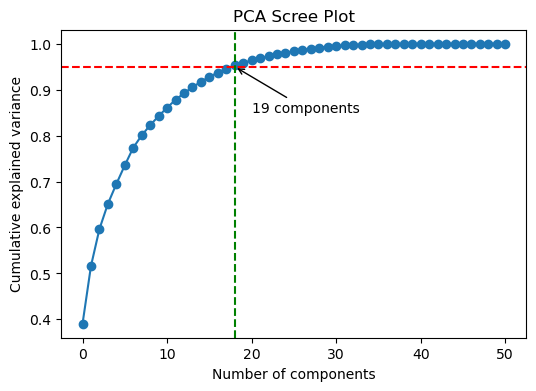

In [25]:
# PCA for visualizing clusters
phys_pca = PCA(n_components=2)
phys_pca_result = phys_pca.fit_transform(phys_features_all)
normalized_phys_data['PCA1'] = phys_pca_result[:, 0]
normalized_phys_data['PCA2'] = phys_pca_result[:, 1]

phys_pca_results_all_clusters = {}

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    phys_pca_result_cluster_k = phys_pca.fit_transform(phys_features_cluster_k)
    normalized_phys_clusters[k]['PCA1'] = phys_pca_result_cluster_k[:, 0]
    normalized_phys_clusters[k]['PCA2'] = phys_pca_result_cluster_k[:, 1]
    phys_pca_results_all_clusters[k] = normalized_phys_clusters[k]

# Scree plot of overall data
phys_pca2 = PCA(n_components = phys_feature_no)
phys_pca2_results = phys_pca2.fit_transform(phys_features_all)

phys_cum_var = np.cumsum(phys_pca2.explained_variance_ratio_)
phys_n_95 = np.argmax(phys_cum_var >= 0.95) + 1

plt.figure(figsize=(6, 4))
plt.plot(phys_cum_var, marker='o')

plt.axhline(y = 0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x = phys_n_95 - 1, color='g', linestyle='--', label=f'{phys_n_95} components')
plt.annotate(f"{phys_n_95} components", xy=(phys_n_95 - 1, 0.95), xytext=(phys_n_95 + 1, 0.85), arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.show()

## Heatmaps

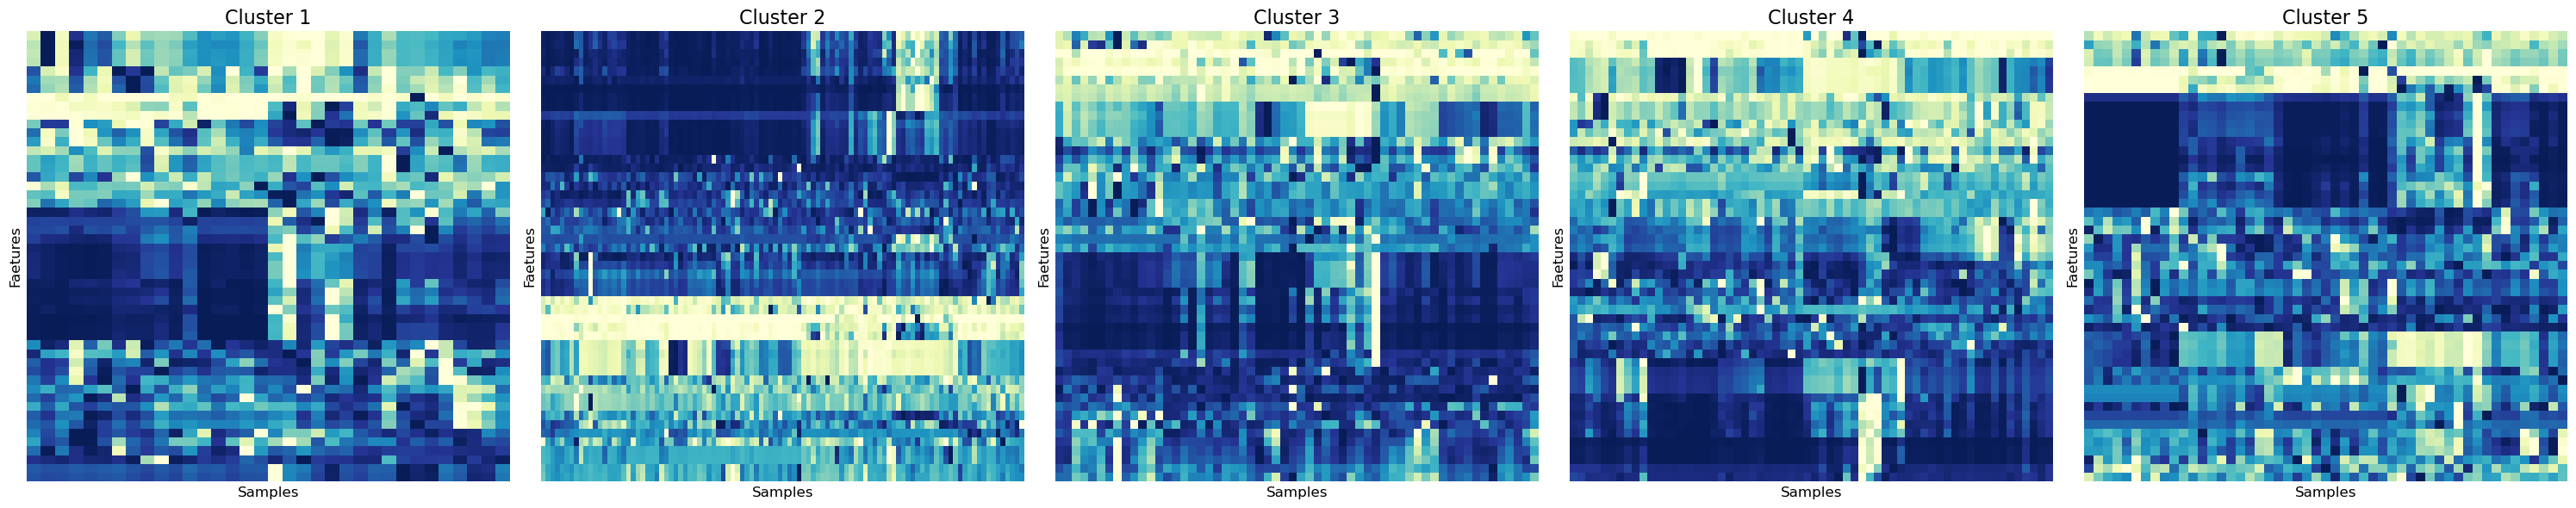

In [26]:
# Set up one figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(6 * n_clusters, 6), squeeze=False)
axes = axes.flatten()

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k.T, method='ward')
    col_order = leaves_list(Z_k)
    ordered_features = phys_features_cluster_k.T.iloc[col_order]
    
    sn.heatmap(ordered_features,
               cmap='YlGnBu_r',
               ax=axes[k],
               cbar=False)
    
    axes[k].set_title(f'Cluster {k+1}', size=16)
    axes[k].set_xlabel('Samples', size=12)
    axes[k].set_ylabel('Faetures', size=12)
    axes[k].set_xticks([])
    axes[k].set_yticks([])

plt.tight_layout()
plt.show()

## PCA

The heatmap displays some signs of clusters, but not as strongly as previously seen.T he projection onto principal components is plotted to further visulize clustering possibilities.

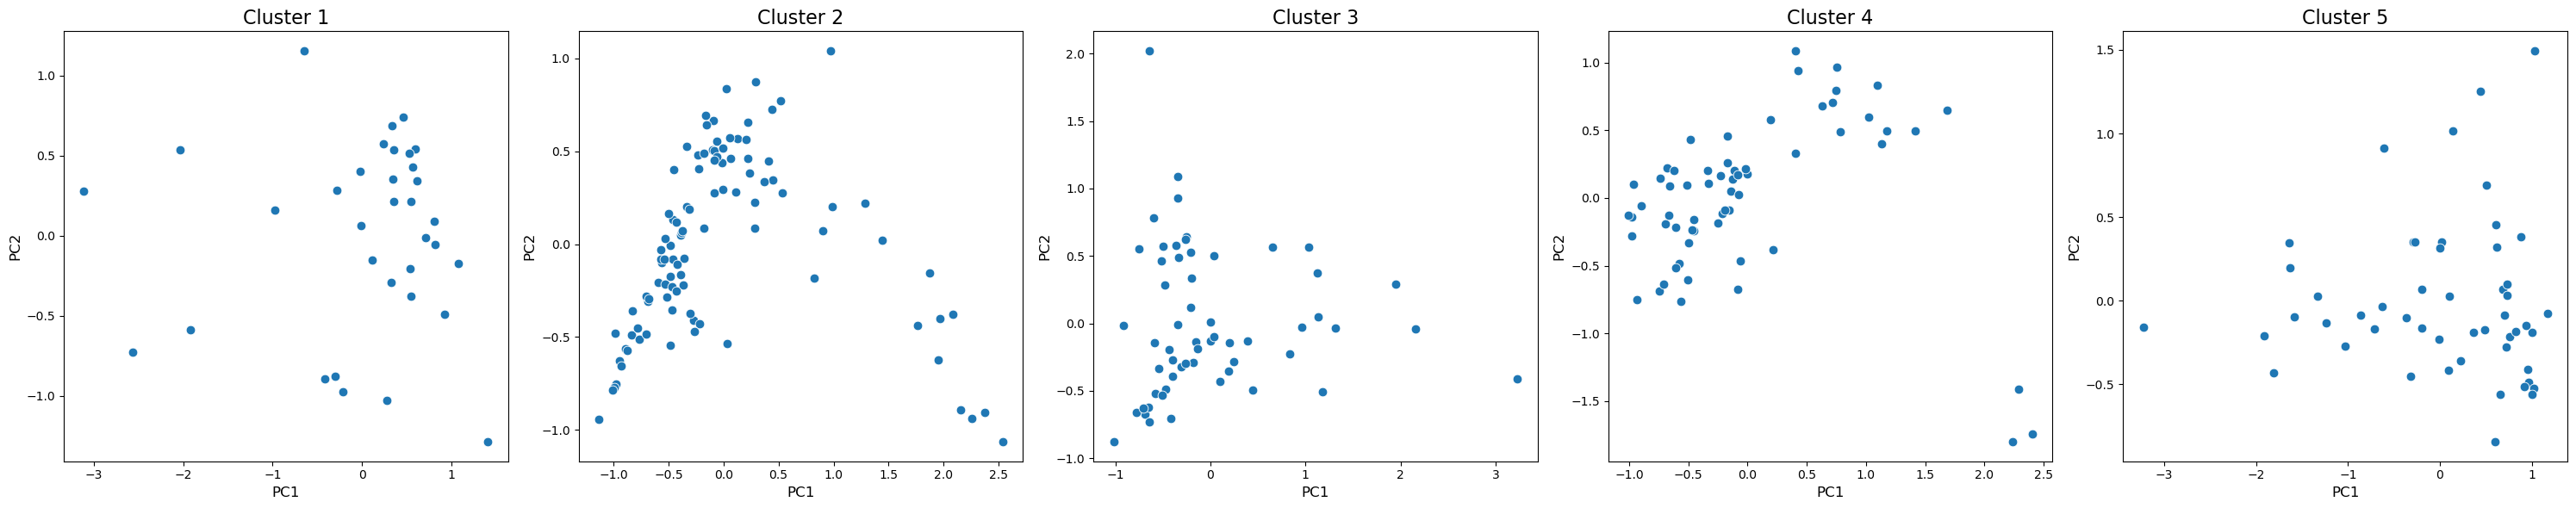

In [27]:
# Set up one figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(6 * n_clusters, 6), squeeze=False)
axes = axes.flatten()

for k in range(n_clusters):
    cluster_pca_data = phys_pca_results_all_clusters[k]
    
    ax = axes[k]
    sn.scatterplot(data=cluster_pca_data, x='PCA1', y='PCA2', ax=ax, s=60)
    
    ax.set_title(f'Cluster {k+1}', size=16)
    ax.set_xlabel('PC1', size=12)
    ax.set_ylabel('PC2', size=12)

plt.tight_layout()
plt.show()

## Hierarchical clustering

Obvious signs of clusters are not present, so hierarchical clustering is used for further exploration, due to the limited sizes of the data subsets.

### Silhouette

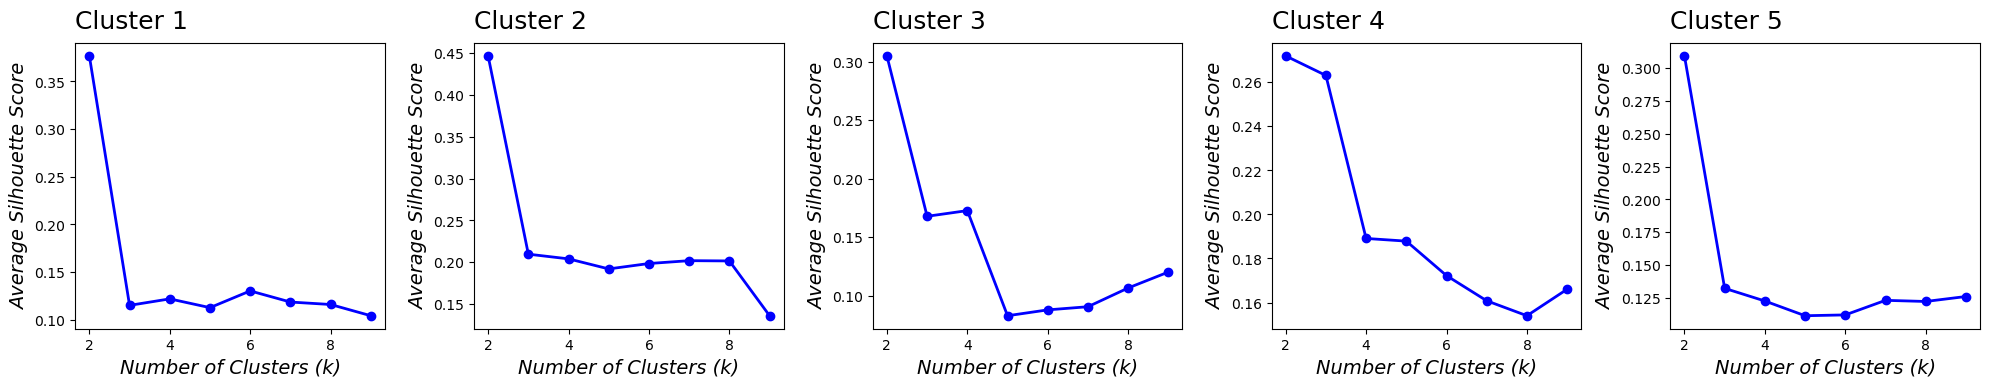

In [28]:
# Set up the figure with subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(20, 4))

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k, method='ward')
    sil_scores = []
    k_values = range(2, 10)
    
    for k_val in k_values:
        labels = fcluster(Z_k, k_val, criterion='maxclust')
        score = silhouette_score(phys_features_cluster_k, labels)
        sil_scores.append(score)
    
    ax = axes[k]
    ax.plot(k_values, sil_scores, 'bo-', linewidth=2)
    ax.set_xlabel("Number of Clusters (k)", size=14, fontstyle='italic')
    ax.set_ylabel("Average Silhouette Score", size=14, fontstyle='italic')
    ax.set_title(f'Cluster {k+1}', y=1.1, pad=-10, loc='left', size=18)

plt.tight_layout()
plt.show()

### Gap statistics

Optimal number of clusters for cluster 1: 10
Optimal number of clusters for cluster 2: 10
Optimal number of clusters for cluster 3: 10
Optimal number of clusters for cluster 4: 10
Optimal number of clusters for cluster 5: 10


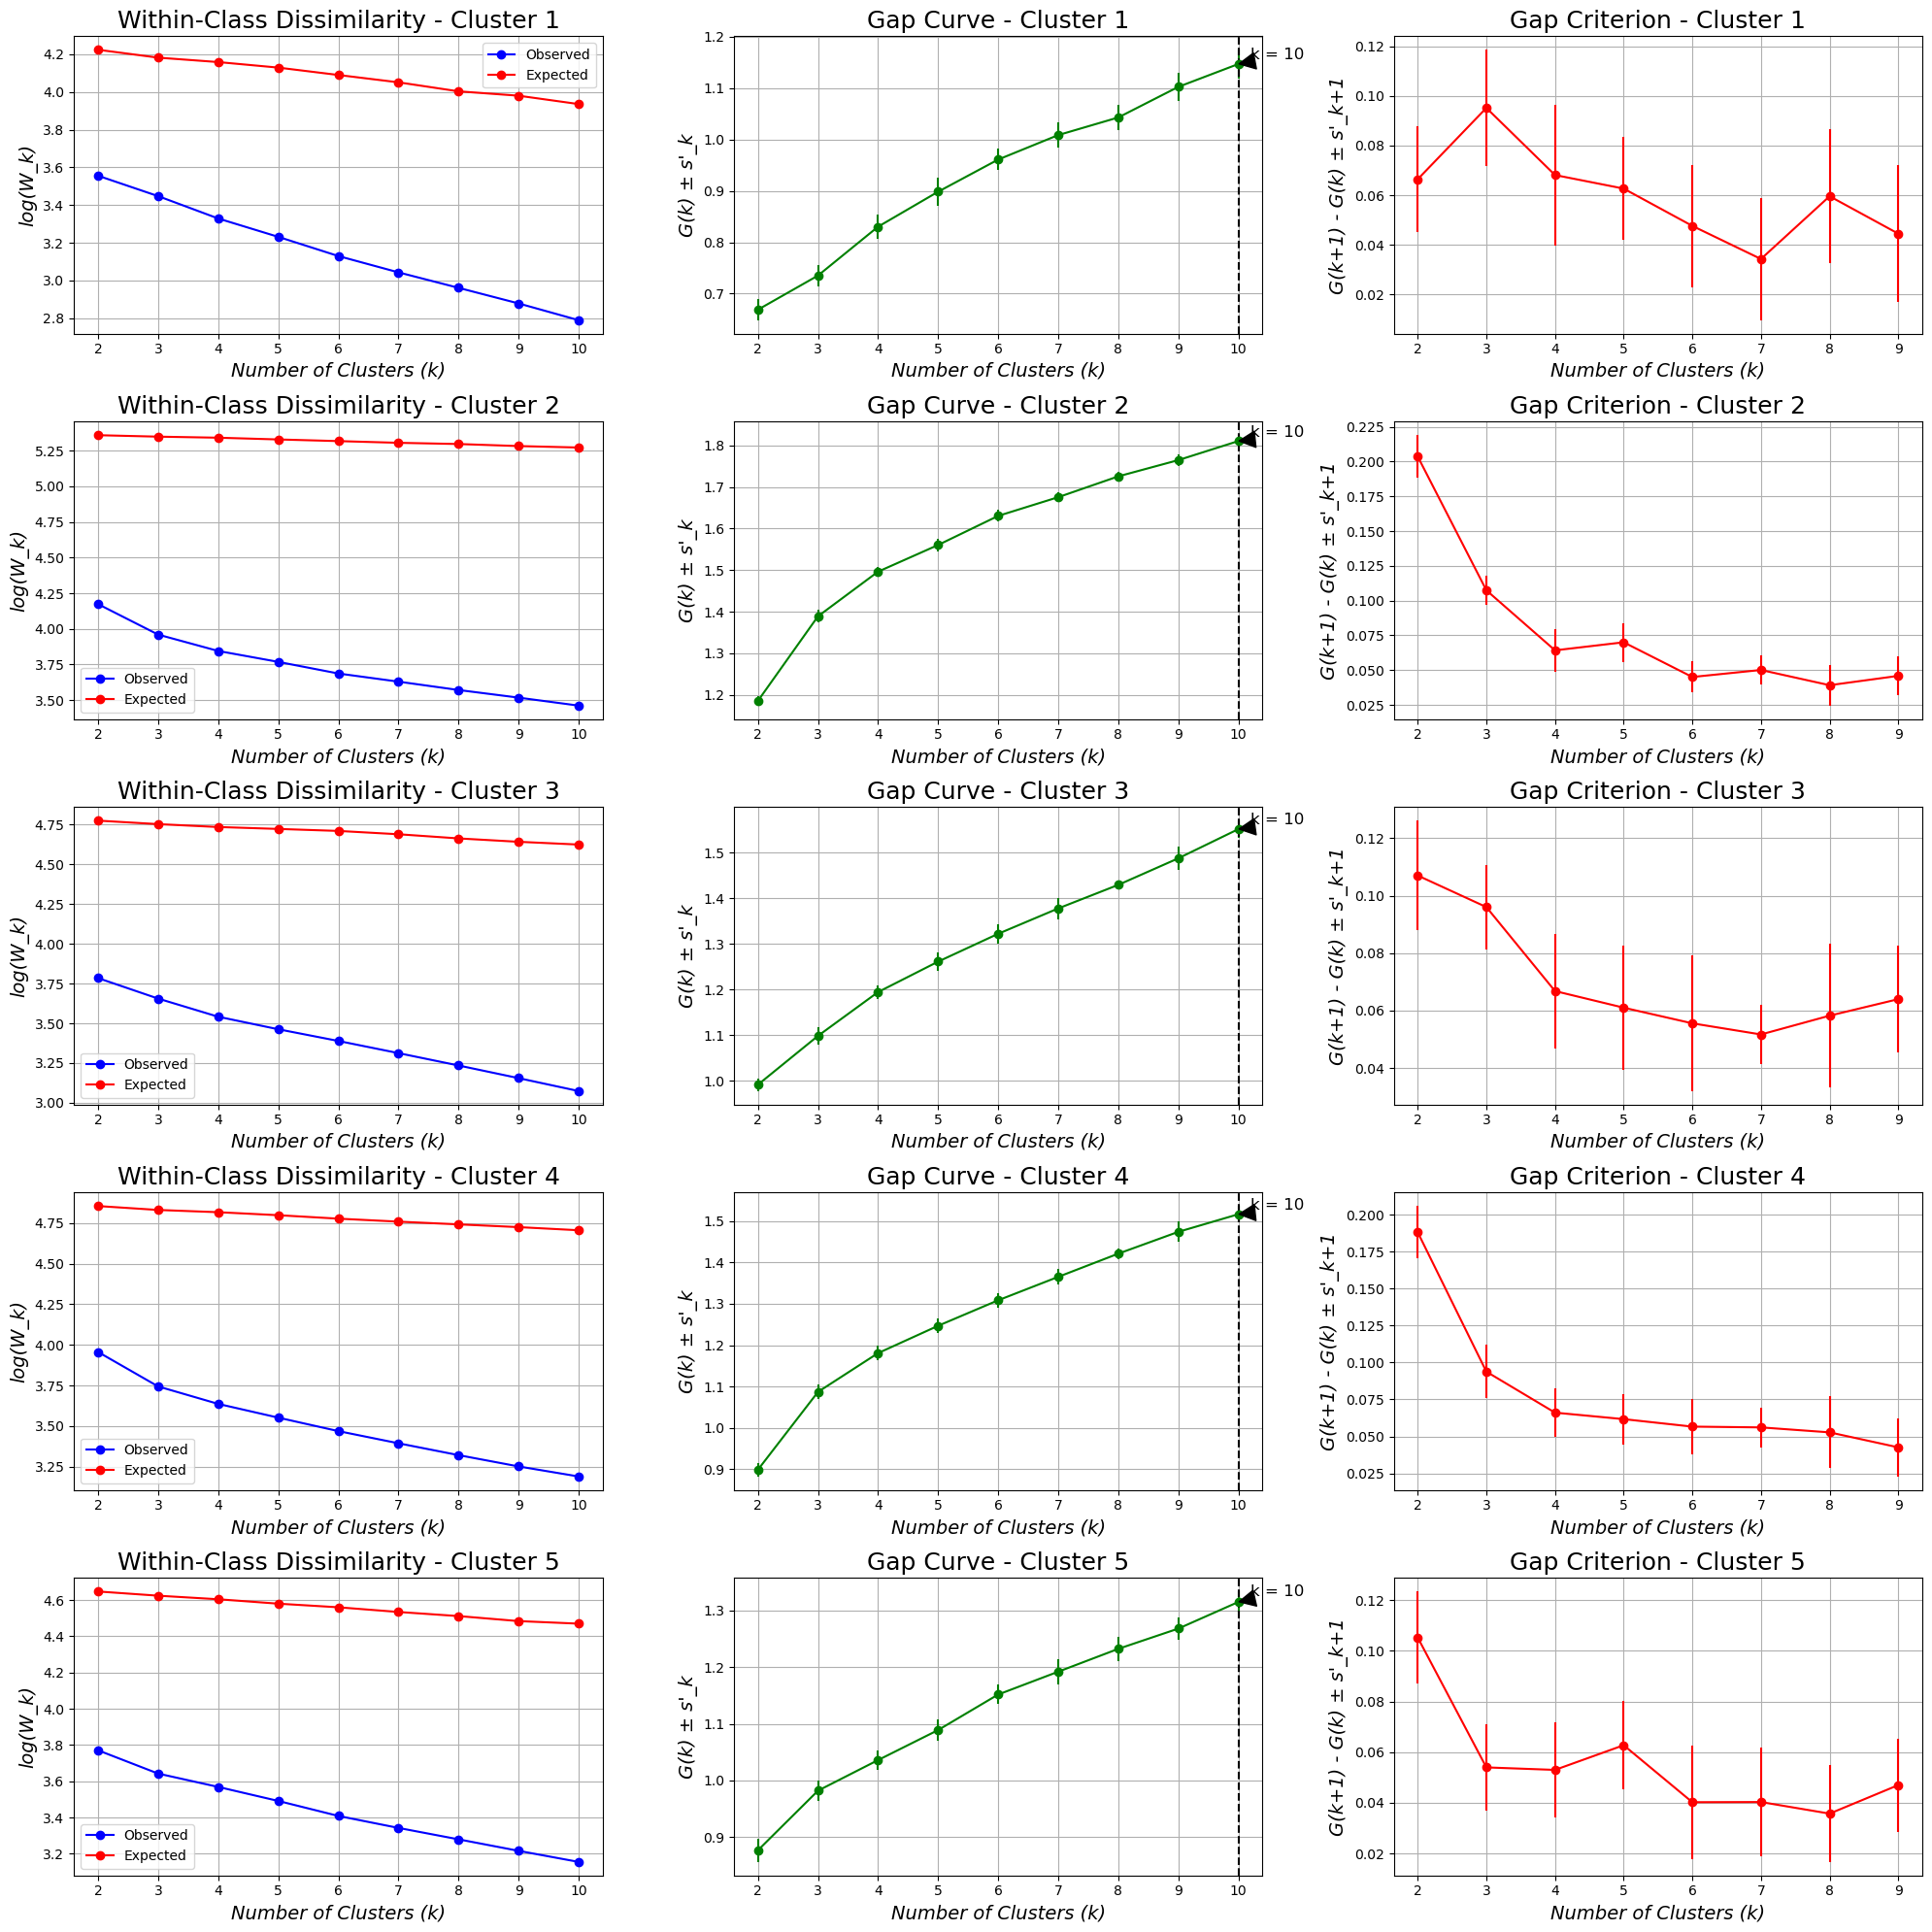

In [29]:
k_clusters = 10
phys_optimal_clusters = {}

# Set figure with 3 cols and n clusters rows
fig, axes = plt.subplots(n_clusters, 3, figsize = (20, 4 * n_clusters))

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    hierach_model = HierarchicalModel(method = 'ward', criterion = 'maxclust')
    
    (phys_log_wk,
     phys_expected_log_wk,
     phys_gaps,
     phys_gap_diff,
     phys_s_k_ref,
     phys_s_prime_k,
     phys_k_1se) = gap_statistics(phys_features_cluster_k, k_clusters, references = 20, random_state = rdst, model = hierach_model)
    
    phys_optimal_clusters[k] = phys_k_1se
    print(f'Optimal number of clusters for cluster {k + 1}: {phys_k_1se}')

    # Plot 1: Within-Class Dissimilarity
    axes[k, 0].plot(range(2, k_clusters + 1), phys_log_wk, marker = 'o', color = 'b', label = 'Observed')
    axes[k, 0].plot(range(2, k_clusters + 1), phys_expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
    axes[k, 0].set_title(f'Within-Class Dissimilarity - Cluster {k + 1}', size = 18)
    axes[k, 0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
    axes[k, 0].grid(True)
    axes[k, 0].legend()

    # Plot 2: Gap Curve
    axes[k, 1].errorbar(range(2, k_clusters + 1), phys_gaps, yerr = phys_s_prime_k, fmt = 'o-', color = 'g', label = 'Gap Statistic')
    axes[k, 1].axvline(x = phys_k_1se, color = 'black', linestyle = '--', label = f'Optimal k = {phys_k_1se}')
    axes[k, 1].annotate(f'k = {phys_k_1se}', 
                 xy = (phys_k_1se, phys_gaps[phys_k_1se - 2]), 
                 xytext = (phys_k_1se + 0.2, phys_gaps[phys_k_1se - 2] + 0.01), 
                 arrowprops = dict(facecolor = 'black', shrink=0.05),
                 fontsize = 12)
    axes[k, 1].set_title(f'Gap Curve - Cluster {k + 1}', size = 18)
    axes[k, 1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
    axes[k, 1].grid(True)

    # Plot 3: Gap Criterion
    axes[k, 2].errorbar(range(2, k_clusters), phys_gap_diff, yerr = phys_s_prime_k[1:], fmt = 'o-', color = 'r', label = 'Gap Criterion')
    axes[k, 2].set_title(f'Gap Criterion - Cluster {k + 1}', size = 18)
    axes[k, 2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
    axes[k, 2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
    axes[k, 2].grid(True)

plt.tight_layout()
plt.show()

### Clustermaps

As the optimal number of clusters determined by gap statistics seem unresonable, and the silhoutte scores continously indicate 2, further analysis will proceed without a set number of clusters.

First, a clustermap is made of clusters 1 through 5.

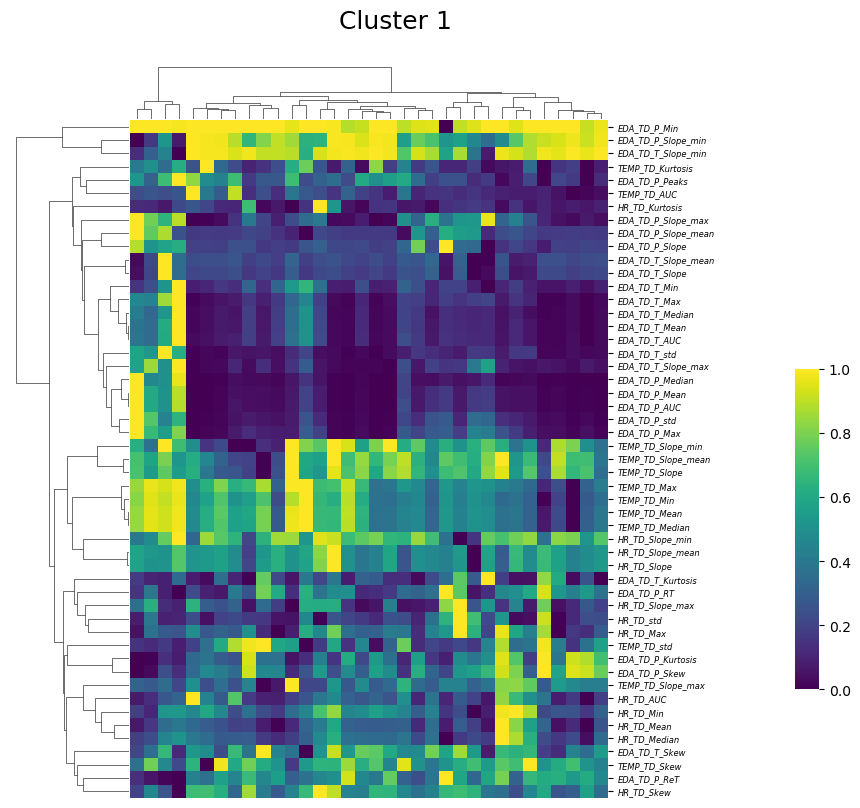

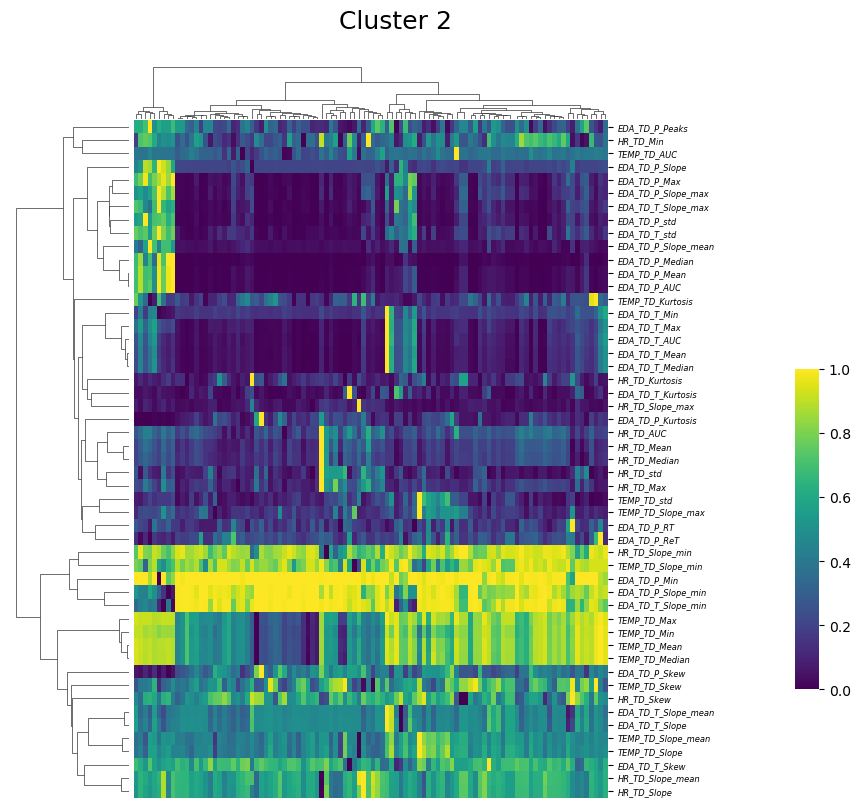

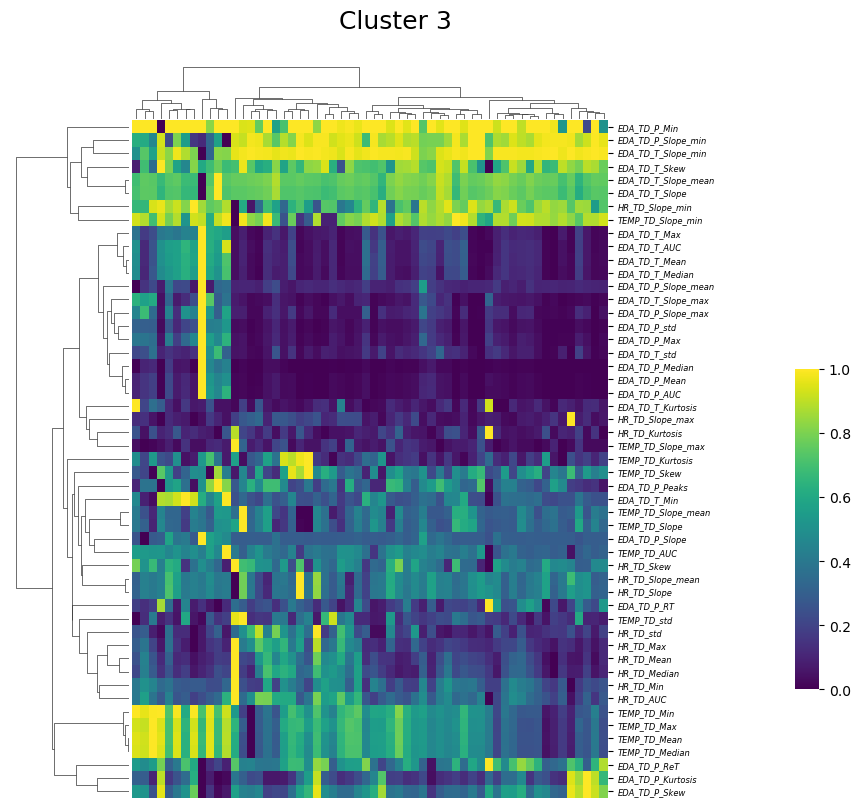

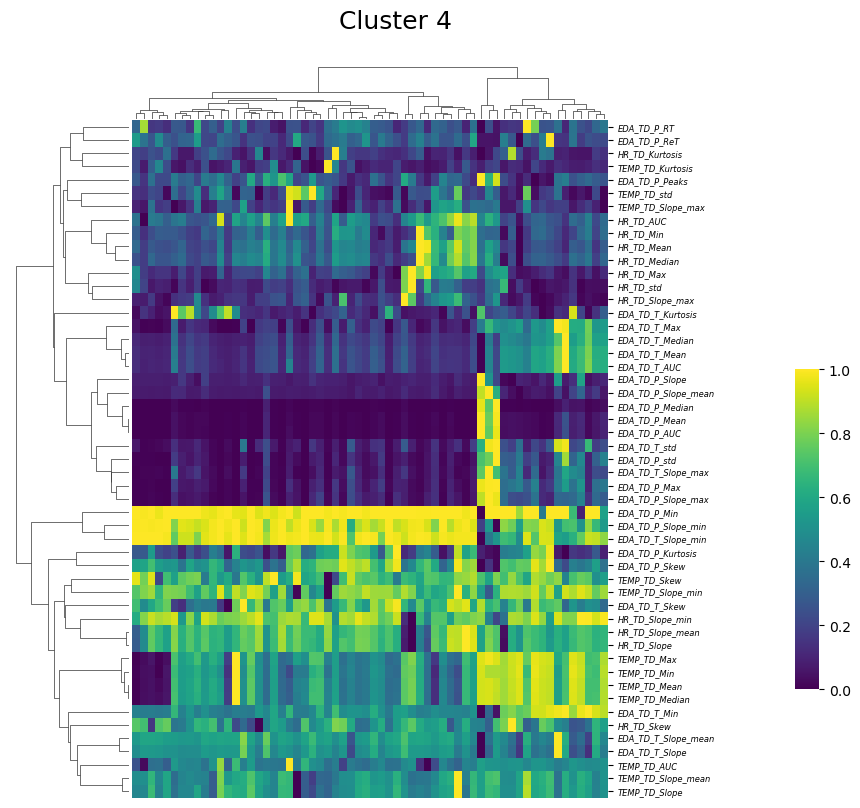

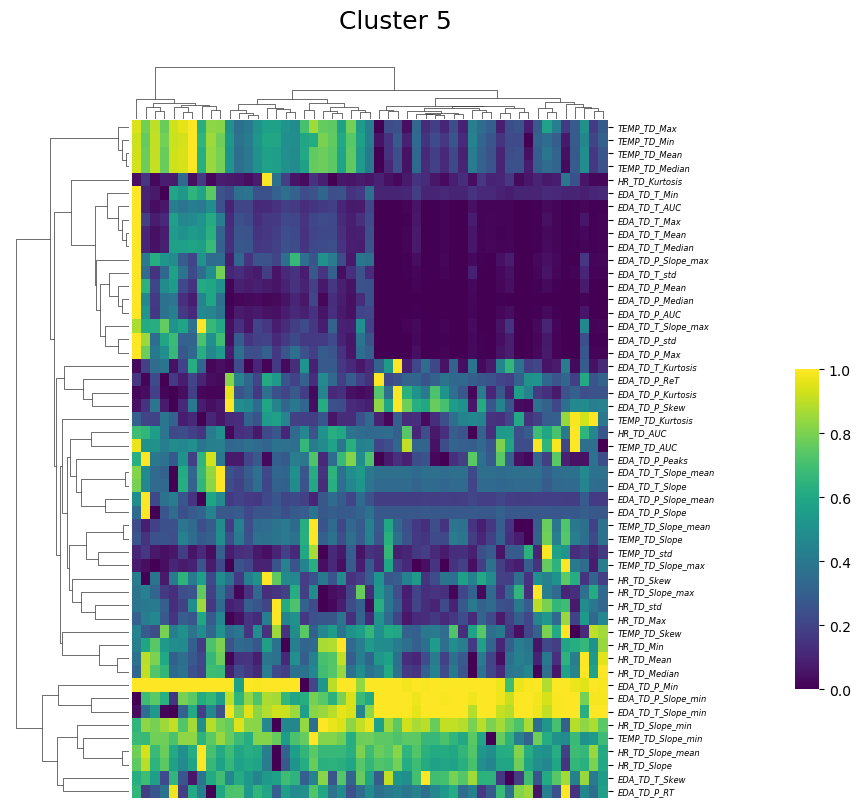

In [30]:
for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    Z_k = linkage(phys_features_cluster_k, method='ward')

    cm = sn.clustermap(phys_features_cluster_k.T, cmap = 'viridis',
              col_linkage = Z_k, row_cluster = True, dendrogram_ratio=(.2, .075),
              figsize = (8, 8), cbar_pos = (1, .2, .03, .4), yticklabels=True)
    
    cm.fig.suptitle(f'Cluster {k+1}', fontsize=18, y=1.05)
    cm.ax_heatmap.set_xticks([])
    cm.ax_heatmap.set_xlabel('')
    cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), rotation=0, fontsize=6, fontstyle = 'italic')

Then, a clustermap is made of all samples.

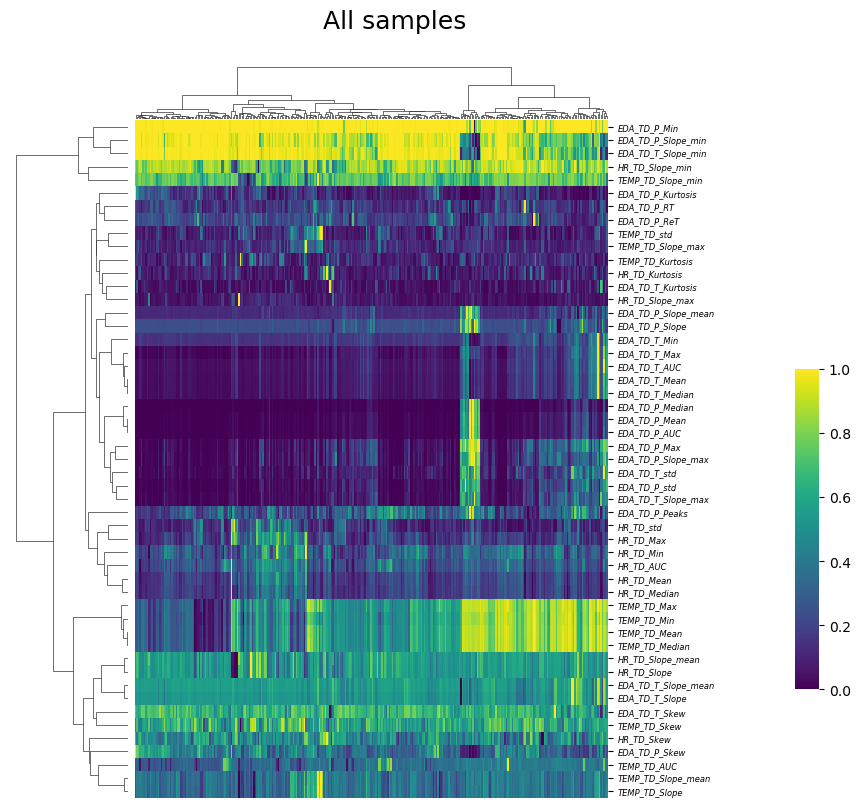

In [31]:
Z_all = linkage(phys_features_all, method='ward')

cm = sn.clustermap(phys_features_all.T, cmap = 'viridis',
                   col_linkage = Z_all, row_cluster = True, dendrogram_ratio=(.2, .075),
                   figsize = (8, 8), cbar_pos = (1, .2, .03, .4), yticklabels=True)
    
cm.fig.suptitle(f'All samples', fontsize=18, y=1.05)
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), rotation=0, fontsize=6, fontstyle = 'italic')

plt.show()

### Characterizing features

The variance of each feature for the whole dataset is computed, in order to distinguish between globally low and high variating features.

In [32]:
feature_variances_all = phys_features_all.var(axis=0)
low_variance_threshold = 0.01
global_low_variance_features = feature_variances_all[feature_variances_all < low_variance_threshold].index.tolist()

print(f'For all samples, there are {len(global_low_variance_features)} low variance features')

For all samples, there are 5 low variance features


The variance is then computed for each cluster.

In [33]:
low_variance_features_per_cluster = {}

for k in range(n_clusters):
    phys_features_cluster_k = phys_features_all_clusters[k]
    variances = phys_features_cluster_k.var(axis=0)
    low_variance_threshold = 0.05
    low_variance_features = variances[variances < low_variance_threshold].index.tolist()
    
    low_variance_features_per_cluster[k] = low_variance_features
    print(f'Cluster {k+1} has {len(low_variance_features)} low variance features')

Cluster 1 has 17 low variance features
Cluster 2 has 39 low variance features
Cluster 3 has 37 low variance features
Cluster 4 has 38 low variance features
Cluster 5 has 32 low variance features


The globally low variance features are removed.

In [35]:
cleaned_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    low_variance_features = low_variance_features_per_cluster[k]
    filtered_low_variance_features = list(set(low_variance_features) - set(global_low_variance_features))
    
    cleaned_low_variance_features_per_cluster[k] = filtered_low_variance_features

    print(f'Cluster {k+1} has {len(filtered_low_variance_features)} low variance features after removing global low variance features')

Cluster 1 has 13 low variance features after removing global low variance features
Cluster 2 has 34 low variance features after removing global low variance features
Cluster 3 has 33 low variance features after removing global low variance features
Cluster 4 has 33 low variance features after removing global low variance features
Cluster 5 has 27 low variance features after removing global low variance features


Remove features present in all 5 clusters.

In [36]:
# Identify
common_low_variance_features = set(cleaned_low_variance_features_per_cluster[0])

for k in range(1, n_clusters):
    common_low_variance_features &= set(cleaned_low_variance_features_per_cluster[k])

print(f'Features that are low variance in all clusters: {common_low_variance_features}')

# Remove
final_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    low_variance_features = cleaned_low_variance_features_per_cluster[k]
    filtered_low_variance_features = list(set(low_variance_features) - common_low_variance_features)
    
    final_low_variance_features_per_cluster[k] = filtered_low_variance_features
    print(f'Cluster {k+1} has {len(filtered_low_variance_features)} low variance features after removing common features')

Features that are low variance in all clusters: {'HR_TD_Kurtosis', 'HR_TD_Slope_mean', 'TEMP_TD_Slope_max', 'HR_TD_Slope', 'EDA_TD_T_Median', 'EDA_TD_T_Mean', 'HR_TD_Skew'}
Cluster 1 has 6 low variance features after removing common features
Cluster 2 has 27 low variance features after removing common features
Cluster 3 has 26 low variance features after removing common features
Cluster 4 has 26 low variance features after removing common features
Cluster 5 has 20 low variance features after removing common features


Remove features present in 4 clusters.

In [37]:
all_low_variance_features = []
for k in range(n_clusters):
    all_low_variance_features.extend(cleaned_low_variance_features_per_cluster[k])

feature_counts = Counter(all_low_variance_features)
features_in_4_clusters = {feature for feature, count in feature_counts.items() if count <= 4}

final_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    low_variance_features = cleaned_low_variance_features_per_cluster[k]
    filtered_low_variance_features = list(set(low_variance_features) & features_in_4_clusters)
    
    final_low_variance_features_per_cluster[k] = filtered_low_variance_features
    print(f'Cluster {k+1} has {len(filtered_low_variance_features)} low variance features present in max 4 clusters after removal')

Cluster 1 has 6 low variance features present in max 4 clusters after removal
Cluster 2 has 27 low variance features present in max 4 clusters after removal
Cluster 3 has 26 low variance features present in max 4 clusters after removal
Cluster 4 has 26 low variance features present in max 4 clusters after removal
Cluster 5 has 20 low variance features present in max 4 clusters after removal


Remove features present in 3 clusters.

In [38]:
all_low_variance_features = []
for k in range(n_clusters):
    all_low_variance_features.extend(cleaned_low_variance_features_per_cluster[k])

feature_counts = Counter(all_low_variance_features)
features_in_3_clusters = {feature for feature, count in feature_counts.items() if count <= 3}

final_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    low_variance_features = cleaned_low_variance_features_per_cluster[k]
    filtered_low_variance_features = list(set(low_variance_features) & features_in_3_clusters)
    
    final_low_variance_features_per_cluster[k] = filtered_low_variance_features
    print(f'Cluster {k+1} has {len(filtered_low_variance_features)} low variance features present in at max 3 clusters after removal')

Cluster 1 has 2 low variance features present in at max 3 clusters after removal
Cluster 2 has 15 low variance features present in at max 3 clusters after removal
Cluster 3 has 15 low variance features present in at max 3 clusters after removal
Cluster 4 has 14 low variance features present in at max 3 clusters after removal
Cluster 5 has 11 low variance features present in at max 3 clusters after removal


Remove features present in 2 clusters.

In [39]:
all_low_variance_features = []
for k in range(n_clusters):
    all_low_variance_features.extend(cleaned_low_variance_features_per_cluster[k])

feature_counts = Counter(all_low_variance_features)
features_in_2_clusters = {feature for feature, count in feature_counts.items() if count <= 2}

final_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    low_variance_features = cleaned_low_variance_features_per_cluster[k]
    filtered_low_variance_features = list(set(low_variance_features) & features_in_2_clusters)
    
    final_low_variance_features_per_cluster[k] = filtered_low_variance_features
    print(f'Cluster {k+1} has {len(filtered_low_variance_features)} low variance features present in at max 2 clusters after removal')

Cluster 1 has 1 low variance features present in at max 2 clusters after removal
Cluster 2 has 5 low variance features present in at max 2 clusters after removal
Cluster 3 has 3 low variance features present in at max 2 clusters after removal
Cluster 4 has 5 low variance features present in at max 2 clusters after removal
Cluster 5 has 1 low variance features present in at max 2 clusters after removal


Identify features unique to each cluster.

In [40]:
unique_low_variance_features_per_cluster = {}

for k in range(n_clusters):
    # Get the low variance features for the current cluster after removing common ones
    low_variance_features = final_low_variance_features_per_cluster[k]
    
    # Start with the set of low variance features for the current cluster
    unique_features = set(low_variance_features)
    
    # Remove features that are also present in other clusters
    for j in range(n_clusters):
        if j != k:  # Avoid comparing with itself
            unique_features -= set(final_low_variance_features_per_cluster[j])
    
    unique_low_variance_features_per_cluster[k] = list(unique_features)
    print(f'Cluster {k+1} has {len(unique_features)} unique low variance features:')
    print(unique_features)

Cluster 1 has 0 unique low variance features:
set()
Cluster 2 has 2 unique low variance features:
{'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew'}
Cluster 3 has 1 unique low variance features:
{'EDA_TD_P_Max'}
Cluster 4 has 0 unique low variance features:
set()
Cluster 5 has 0 unique low variance features:
set()
